<h2>Imports & Configuration</h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42


In [5]:
"""
Business Objective:
Identify high-risk customers using clean, stable, and interpretable features.

Preprocessing KPIs:
- Missing values handled
- Stable numeric distributions
- Reduced redundancy
- Meaningful categorical encoding
- Anomaly identification
"""

#3. Load Dataset
df = pd.read_csv("d:/datasets/dpp/week5_hr_dataset.csv")
df.head()



,Employee_ID,Hire_Date,Last_Promotion_Date,Last_Login_Timestamp,Department,Job_Role,Job_Level,City,Education,Work_Mode,...,Performance_Rating,Training_Hours,Overtime_Hours,Projects_Count,Absenteeism_Days,Employee_Comment,Customer_Review,Notes_Raw_Data,Satisfaction_Score,Attrition_Flag
0,E100000,2015-11-06 12:32:07,2016-08-16 12:32:07,2025-10-19 09:58:14,Operations,Lead,3,Mumbai,Bachelors,Hybrid,...,3.1,47,33,4,4,"Training was helpful, want more advanced sessi...",Amazing service! Fast delivery 😊,N/A###$$$,79.5,0
1,E100001,2022-05-08 01:54:35,2022-10-23 01:54:35,2025-10-02 19:18:32,Finance,Analyst,1,Delhi,Masters,Onsite,...,2.3,2,32,7,3,"Training was helpful, want more advanced sessi...",Not satisfied. Product arrived damaged.,###REF!@#$$,63.0,0
2,E100002,2021-03-20 01:17:47,2021-10-05 01:17:47,2025-11-09 07:04:38,IT,Analyst,4,Pune,Masters,Remote,...,3.1,56,31,3,9,Communication from leadership is excellent!,Worst experience ever!!! 😡😡,$$$ERROR_404!!!,59.4,1
3,E100003,2019-03-03 00:43:49,2023-12-11 00:43:49,2025-11-09 02:44:48,Finance,Manager,4,Chennai,Masters,Onsite,...,2.2,39,40,7,5,Promotion process feels slow…,Worst experience ever!!! 😡😡,###@!@!@###,56.5,1
4,E100004,2019-02-10 16:43:26,2023-09-30 16:43:26,2025-11-02 23:13:56,HR,Engineer,3,Pune,Bachelors,Hybrid,...,3.7,0,55,2,2,"Training was helpful, want more advanced sessi...",Loved the packaging and quick response time.,$$$ERROR_404!!!,46.9,0


In [6]:
#Dataset Overview
print("Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())


Shape: (1000, 24)

Data Types:
 Employee_ID              object
Hire_Date                object
Last_Promotion_Date      object
Last_Login_Timestamp     object
Department               object
Job_Role                 object
Job_Level                 int64
City                     object
Education                object
Work_Mode                object
Marital_Status           object
Membership_Type          object
Age                       int64
Base_Salary             float64
Performance_Rating      float64
Training_Hours            int64
Overtime_Hours            int64
Projects_Count            int64
Absenteeism_Days          int64
Employee_Comment         object
Customer_Review          object
Notes_Raw_Data           object
Satisfaction_Score      float64
Attrition_Flag            int64
dtype: object

Missing Values:
 Employee_ID             0
Hire_Date               0
Last_Promotion_Date     0
Last_Login_Timestamp    0
Department              0
Job_Role                0
Job_Level   

In [8]:
#Train–Test Split (Prevent Data Leakage)
X = df.drop("Attrition_Flag", axis=1)
y = df["Attrition_Flag"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)


In [9]:
#Identify Feature Types
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X_train.select_dtypes(include=["object"]).columns


In [10]:
# Numeric Preprocessing Pipeline
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])


In [11]:
#Categorical Preprocessing Pipeline
categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])


In [12]:
# Combine Pipelines using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numeric_features),
        ("cat", categorical_pipeline, categorical_features)
    ]
)


In [13]:
#Apply Preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Processed Train Shape:", X_train_processed.shape)
print("Processed Test Shape:", X_test_processed.shape)


Processed Train Shape: (800, 3196)
Processed Test Shape: (200, 3196)


In [14]:
#Remove Low-Variance Features
variance_filter = VarianceThreshold(threshold=0.01)

X_train_var = variance_filter.fit_transform(X_train_processed)
X_test_var = variance_filter.transform(X_test_processed)

print("After Variance Threshold:", X_train_var.shape)


After Variance Threshold: (800, 105)


In [15]:
#Dimensionality Reduction (PCA)
pca = PCA(n_components=0.95, random_state=RANDOM_STATE)

X_train_pca = pca.fit_transform(X_train_var)
X_test_pca = pca.transform(X_test_var)

print("After PCA:", X_train_pca.shape)
print("Explained Variance:", pca.explained_variance_ratio_.sum())


After PCA: (800, 52)
Explained Variance: 0.950414664516106


In [17]:
#Anomaly Detection (LOF & Isolation Forest)

#LOF (Training Only)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
lof_labels = lof.fit_predict(X_train_pca)

#Isolation Forest (Train + Test)
iso = IsolationForest(
    contamination=0.05,
    random_state=RANDOM_STATE
)

iso.fit(X_train_pca)
iso_train_labels = iso.predict(X_train_pca)
iso_test_labels = iso.predict(X_test_pca)


In [18]:
#Add Anomaly Flags as Features
X_train_final = np.column_stack([
    X_train_pca,
    (iso_train_labels == -1).astype(int)
])

X_test_final = np.column_stack([
    X_test_pca,
    (iso_test_labels == -1).astype(int)
])

print("Final Train Shape:", X_train_final.shape)


Final Train Shape: (800, 53)


In [19]:
#Preprocessing Impact Summary
impact_summary = {
    "Initial Features": X.shape[1],
    "After Encoding": X_train_processed.shape[1],
    "After Variance Filter": X_train_var.shape[1],
    "After PCA": X_train_pca.shape[1],
    "Final Feature Count": X_train_final.shape[1]
}

pd.DataFrame.from_dict(
    impact_summary, orient="index", columns=["Count"]
)


,Count
Initial Features,23
After Encoding,3196
After Variance Filter,105
After PCA,52
Final Feature Count,53


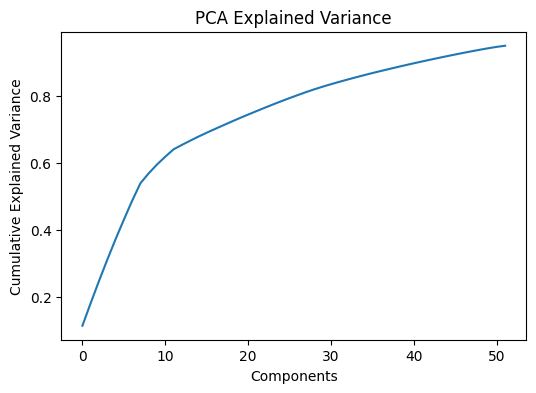

In [20]:
#Visual Validation
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.show()


In [ ]:
#Final Notes & Documentation
"""
Final Observations:
- Missing values handled without leakage
- Feature scales normalized
- Redundant features reduced
- 95% variance preserved via PCA
- Anomalies flagged instead of removed

This pipeline is:
✔ Reproducible
✔ Interpretable
✔ Production-ready
"""
